<a href="https://colab.research.google.com/github/dayanandv/Dynamic-Graphs_Evolutionary-IM/blob/master/Dynamic_Graphs_Evolutionary_IM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Author: Dayanand V (CB.EN.D*CSE17003-PT)

This is an attempt to model *Evolutionary IM experiment on dynamically evolving random graphs*

Reference: The paper 'Modeling multi-source information diffusion: A graphical evolutionary game approach' by Hong Hu, Yuejiang Li, H.V Zhao and Yan Chen at 2019 Asia-Pacific Signal and Information Processing Association Annual Summit and Conference, APSIPA ASC 2019.

In [ ]:
import networkx as nx
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange, tqdm, tqdm_notebook
from itertools import cycle
import numpy as np

In [ ]:
N = 2000    #Number of users
k = 20      #Average degree
p = k/N     #Probability that a node connects with any of it's arbitrary neighbour, might be same as the alpha (selection parametr) mentioned in the paper
G_N = 40 #Number of times the graph has to be regenerated
S_M = 1000  #Number of times simulations have to be conducted on one graph
payoff_matrix = [[0.4, 0.48, 0.48, 0.64],\
                 [0.48, 0.24, 0.64, 0.32],\
                 [0.48, 0.64, 0.24, 0.32],\
                 [0.64, 0.32, 0.32, 0.2]] #Initialized based on Equation (26)
strategy_percentages = [0.1, 0.2, 0.3, 0.4] #Taking advantage of the index here, there are four strategies, viz 0, 1, 2, and 3
final_results = [strategy_percentages]
simulations_results_collection = {}
no_of_iterations = 0

#----------------------------------------------------Dynamics----------------------------------------------------
change_percentage_add_nodes = 0.01 #Percentage of node additions expected in a graph per iteration (Dynamicity)
change_percentage_remove_nodes = 0.001 #Percentage of node removals expected in a graph per iteration (Dynamicity)
change_percentage_add_edges = 0.01 #Percentage of edge additions expected in a graph per iteration (Dynamicity)
change_percentage_remove_edges = 0.01 #Percentage of edge removals expected in a graph per iteration (Dynamicity)

In [ ]:
def plot_strategy_evolution(results_df, number_of_graphs, number_of_simulations):
    plt.figure(figsize=(24, 6))
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set_style("whitegrid", {"axes.facecolor": ".9"})
    plt.xlabel("Iterations")
    plt.ylabel("Strategy percentage value")
    plt.title("Strategy vs Iterations (" + str(number_of_graphs) + " Graphs with " + str(number_of_simulations) +" simulations each)")
    sns.lineplot(data=results_df, dashes=False)

In [ ]:
def update_strategy_percentage(G):
    strategy_counts = [0, 0, 0, 0]
    for user in list(G.nodes()):
        strategy_counts[int(G.nodes[user]['strategy'])] += 1
    return [count / G.number_of_nodes() for count in strategy_counts]

In [ ]:
#Initializes the user strategy according to the strategy_percentages fractions for 'number_of_nodes' users with id starting from start_id
def initialize_strategies(start_id, number_of_nodes):
    if(number_of_nodes>0):
        strategies = np.random.choice(len(strategy_percentages), number_of_nodes, p=strategy_percentages)
        for i in range(number_of_nodes): #For each user, do
            G.nodes[start_id+i]['strategy'] = strategies[i] # 1.1 Initialize users' strategy
            G.nodes[start_id+i]['fitness'] = payoff_matrix[strategies[i]][strategies[i]] # 1.2 Calculate each user's fitness value
    else:
        print("No new nodes to initialize")

In [ ]:
def evolve_graph(G):
    #------------------------------------Graph evolves here--------------------------------------------------
    #----------Introducing new nodes into the graph and connecting them----------
    node_count = G.number_of_nodes()
    for i in range(int(node_count*change_percentage_add_nodes)):
        node_id = node_count+i
        G.add_node(node_id) #Add a new node with id continuing from last added id
        G.add_edges_from(zip(cycle([node_id]), random.sample(G.nodes(),int(p*N)))) #Create edges from the newly added node to other nodes in the graph with probability 'p' 
    initialize_strategies(start_id=node_count, number_of_nodes=i+1) #Initialize the strategies for the newly added nodes
    node_count = G.number_of_nodes()
    #----------------------------------------------------------------------------

    #---------------Removing nodes from the current graph------------------------
    G.remove_nodes_from(random.sample(G.nodes(),int(G.number_of_nodes()*change_percentage_remove_nodes))) ##Remove nodes from the current set of nodes with probability 'change_percentage_remove_nodes' 
    #----------------------------------------------------------------------------
    #######################################################################################################################
    #TO FIX: SOMEHOW NUMBER OF NODES DELETED IS MORE THAN NUMBER OF NODES ADDED, GRADUALLY DECREASING THE SIZE OF THE GRAPH
    #######################################################################################################################

    #------------------Adding edges to the current graph-------------------------
    #----------------------------------------------------------------------------

    #---------------Removing edges from the current graph------------------------
    #----------------------------------------------------------------------------

    #--------------------------------------------------------------------------------------------------------
    return G

In [ ]:
for i in tqdm_notebook(range(G_N),desc='Graphs'): #Regerate graphs G_N times
    #print("Graph #", i, "is created. Strategy percentages are:",strategy_percentages)
    G = nx.erdos_renyi_graph(N, p, seed = 100) #Generating random graph
    intermediate_results = [strategy_percentages] #List to store strategy percentages of each simulation on this graph, initialize it with the default values
    current_strategy_percentages = strategy_percentages
    initialize_strategies(0, N) #Initialize the user strategy according to the strategy_percentages fractions for the entire graph

    for j in tqdm_notebook(range(S_M), desc='Simulations', leave=False):  #Simulation running S_M times
        
        no_of_iterations += 1

        G = evolve_graph(G) #Let graph evolve
        #print(G.number_of_nodes(), end=",")

        user = random.choice(list(G.nodes())) # 2. Choose a focal user randomly
        if (len([n for n in G.neighbors(user)])!=0): #If the user has neighbors
            neighbor = random.choice(list(G.neighbors(user))) # 3. Choose a neighbor to replicate the strategy
        else:
            continue

        if (G.nodes[user]['strategy'] == G.nodes[neighbor]['strategy']): # 4. If neighbor's strategy is same as focal user's
            #strategy[s]['percentage'] = '''calculated value''' #Unclear what this means if it's the same value
            pass
        else:
            if(payoff_matrix[G.nodes[user]['strategy']][G.nodes[user]['strategy']]<payoff_matrix[G.nodes[neighbor]['strategy']][G.nodes[neighbor]['strategy']]):
                G.nodes[user]['strategy'] = G.nodes[neighbor]['strategy'] # 4.1 Update the strategy of focal user to that of neighbor's (This should be based on the probability function's output; refer equation #7 and equation #10 in the paper)
                G.nodes[user]['fitness'] = payoff_matrix[G.nodes[user]['strategy']][G.nodes[neighbor]['strategy']] # 4.2 Re-calculate fitness 
        current_strategy_percentages = update_strategy_percentage(G) # 5 Record each strategy's percentage
        #strategy_percentages = update_strategy_percentage(G) # 5 Record each strategy's percentage
        intermediate_results.append(current_strategy_percentages)
        #intermediate_results.append(strategy_percentages)

        #-------------------------------------------------------------------------------------------------------------------
        #strategy_percentages = current_strategy_percentages #Strategy percentages are carried forward even for future graphs
        #Comment the above line to start each graph with strategies reset to the original strategy_percentages values
        #--------------------------------------------------------------------------------------------------------------------

        #print("After simulation #",j+1, ", strategy values are:", current_strategy_percentages) # 6. Record/Output the simulation experiment's results
    intermediate_results_df = pd.DataFrame(intermediate_results)
    intermediate_results_df.columns=['s0','s1','s2','s3']
    simulations_results_collection[i] = intermediate_results_df
    final_results.append(intermediate_results_df.mean(axis = 0)) # Append each strategy's average percentage values in this simulation to the final result collection

final_results_df = pd.DataFrame(final_results)
final_results_df.columns=['s0','s1','s2','s3']
#final_results_df.to_csv("results_" + time.strftime("%H%M%S_%d%m%Y") + ".csv", index=True, index_label='iteration') # 8. Record/Output the final average results

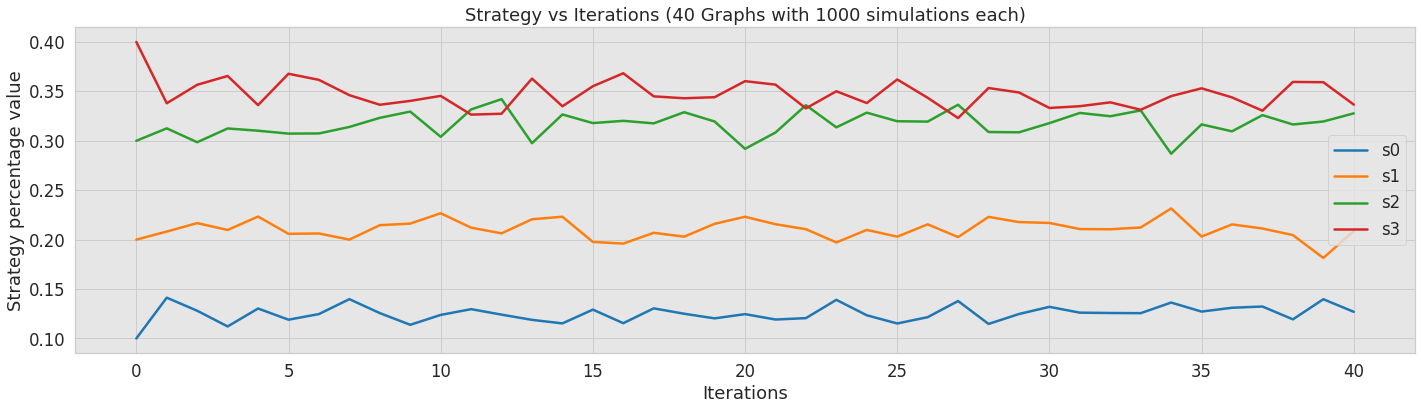

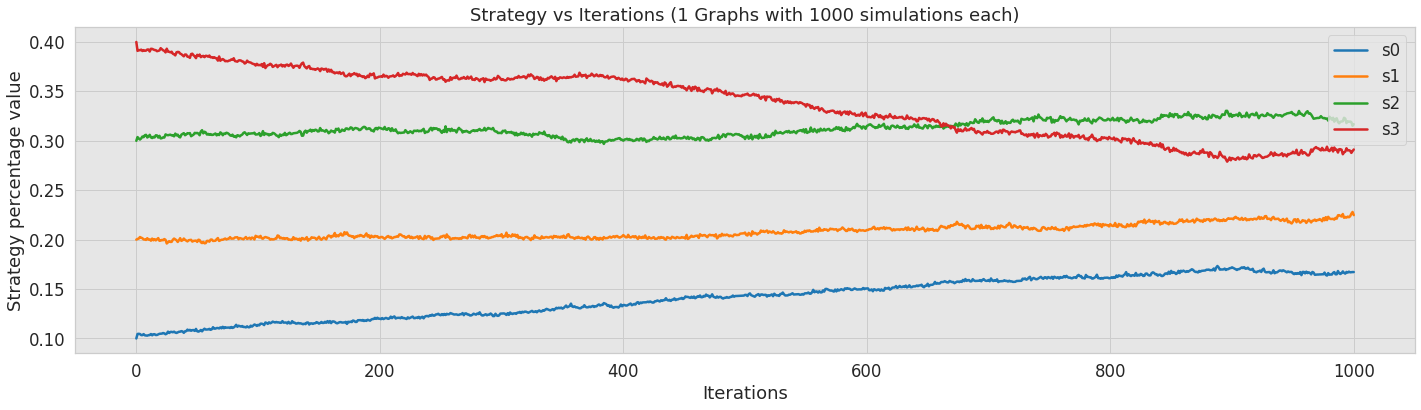

In [ ]:
plot_strategy_evolution(final_results_df, number_of_graphs=G_N, number_of_simulations=S_M)
plot_strategy_evolution(simulations_results_collection[0], number_of_graphs=1, number_of_simulations=S_M)

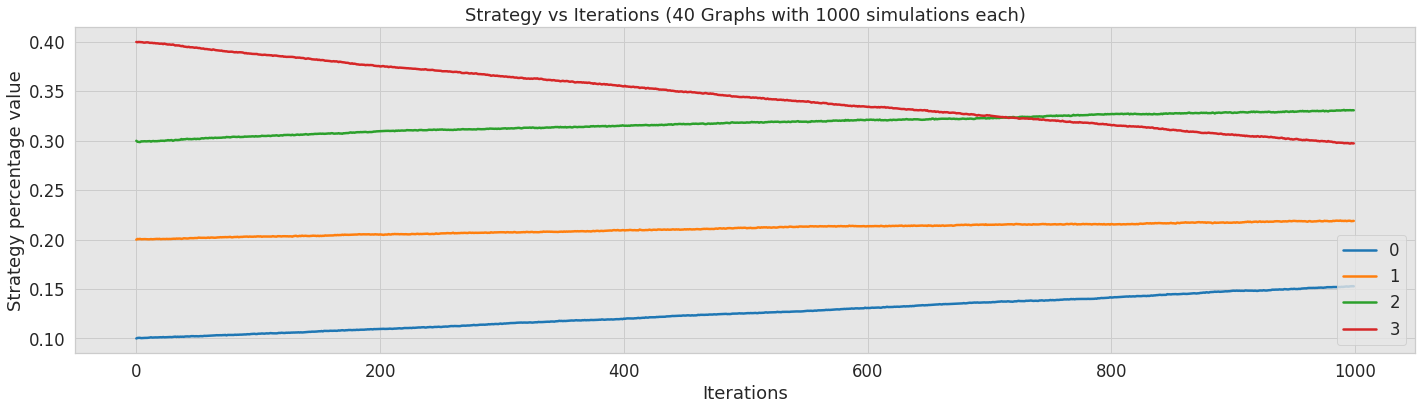

In [ ]:
strategy_averages = []
for simulation_iter in range(S_M):
    strategy_percentages_values_in_one_iter = []
    for graph in range(G_N):
        strategy_percentages_values_in_one_iter.append(list(simulations_results_collection[graph].iloc[simulation_iter]))
    strategy_percentages_values_in_one_iter_df = pd.DataFrame(strategy_percentages_values_in_one_iter)
    strategy_averages.append(strategy_percentages_values_in_one_iter_df.mean(axis = 0))
strategy_averages_df = pd.DataFrame(strategy_averages)
plot_strategy_evolution(strategy_averages_df, number_of_graphs=G_N, number_of_simulations=S_M)

In [ ]:
G.number_of_nodes()

1247